## Dimensionality Reduction

Dimensionality reduction is a technique used in machine learning and statistics to reduce the number of features or variables in a dataset while preserving its essential characteristics. This is particularly useful when dealing with high-dimensional data, as it can help improve model performance, reduce overfitting, and make data visualization easier.

First we will import the required libraries and read in some precipitation imagery.

In [ ]:
import geowombat as gw
import os
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import ray
import pandas as pd


os.chdir("../xr_fresh/data/")


file_glob = f"evi_*tif"
files = sorted(glob(file_glob))

# print dates and files in a table
pd.DataFrame({  "file": files})

/home/mmann1123/miniconda3/envs/xr_fresh_update/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,file
0,evi_20160101.tif
1,evi_20160401.tif
2,evi_20160517.tif
3,evi_20170203.tif


Let's take a look at the imput data

<xarray.DataArray (time: 4, band: 1, y: 403, x: 515)>
dask.array<where, shape=(4, 1, 403, 515), dtype=float64, chunksize=(1, 1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
  * time     (time) int64 1 2 3 4
Attributes: (12/13)
    transform:           (5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
    crs:                 32618
    res:                 (5.0, 5.0)
    is_tiled:            1
    nodatavals:          (-9999,)
    _FillValue:          -9999
    ...                  ...
    offsets:             (0.0,)
    filename:            ['evi_20160101.tif', 'evi_20160401.tif', 'evi_201605...
    resampling:          nearest
    AREA_OR_POINT:       Area
    _data_are_separate:  1
    _data_are_stacked:   1

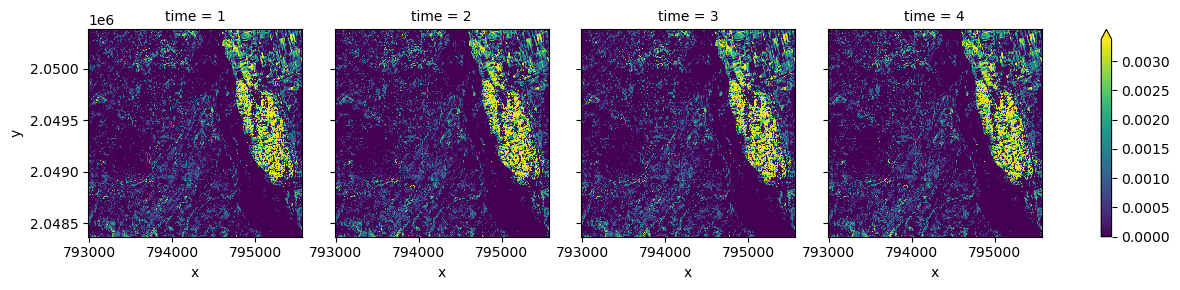

In [5]:
with gw.open(files,   nodata=-9999 ) as ds:
    ds = ds.gw.mask_nodata()
    ds.plot(col="time", col_wrap=4, cmap="viridis", robust=True)
    display(ds)

Now let's create 3 components from the data 

2025-05-21 12:34:15,786	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(raylet) E0521 12:34:16.052672958  913438 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(process_window pid=913473) E0521 12:34:18.642525558  913473 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


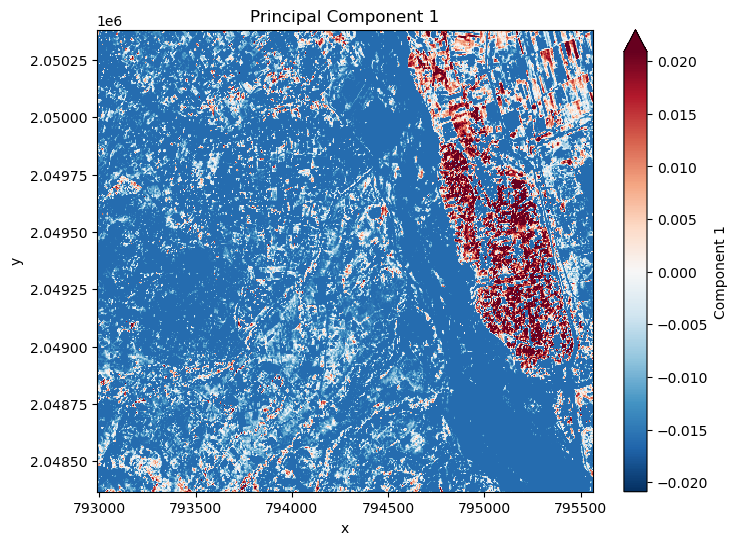

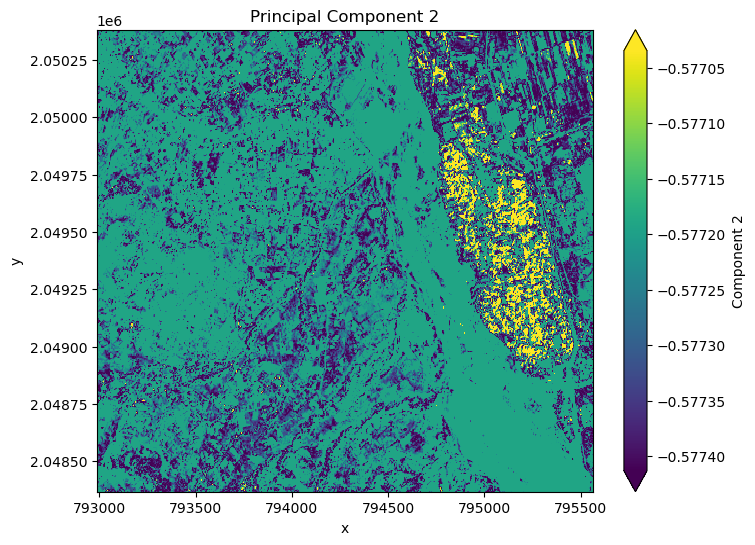

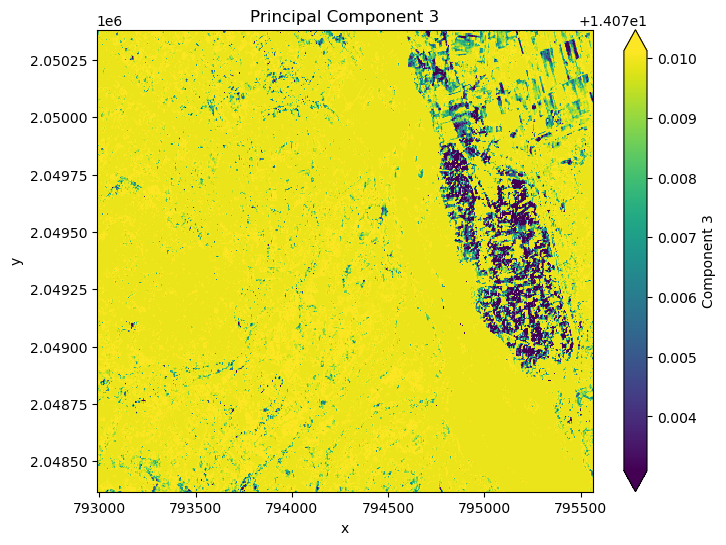

(process_window pid=913470) E0521 12:34:18.885647072  913470 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 3x across cluster]


In [6]:
import xr_fresh.dimension_reduction  # This registers the accessor
cpus = 8
with ray.init(num_cpus=cpus) as rays:

    # Example usage
    with gw.open(
        files,
        stack_dim="band",
        nodata=-9999
    ) as src:
        src = src.gw.mask_nodata()
        # get 3 k principal components - base zero counting
        transformed_dataarray = src.gw_ext.k_pca(
            gamma=15, n_components=3, n_workers=cpus, chunk_size=512
        )
        
        # plot each with a seperate scale 
        for i, comp in enumerate(transformed_dataarray.component.values):
            transformed_dataarray.sel(component=comp).plot.imshow(
                figsize=(8, 6), robust=True, cbar_kwargs={'label': f'Component {i+1}'}
            )
            plt.title(f'Principal Component {i+1}')
            plt.show()

Save your outputs 

In [4]:
transformed_dataarray.gw.save(
    "test.tif",
    overwrite=True,
)

100%|██████████| 104233/104233 [00:05<00:00, 18256.39it/s]
